# Trends of word usage in IETF mailing lists

This notebook is based on the example notebook [Check Word Trends Over Time](https://github.com/datactive/bigbang/blob/master/examples/word_analysis/CheckWordsTrendsOverTime.ipynb).

What it does:

* it computes and plot word counts over time, on aggregated mailing lists' data.

Parameters to set options:

* it can track one or more words, according to the number of words set in the variable `checkwords` 
* it can look in one or more mailing lists, according to how many urls are set; word counts are aggregated across mls
* it can look at literal words or at stemmed words, according to the `stem` parameter

### Imports

In [1]:
%matplotlib inline

In [3]:
from bigbang.archive import load as load_archive
from bigbang.archive import Archive
import bigbang.archive as archive
import bigbang.mailman as mailman
import bigbang.process as process
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz
import numpy as np
import math
import nltk
from itertools import repeat
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from nltk.corpus import stopwords
import re
import os

In [35]:
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

## Gathering data

In [5]:
#insert a list of the urls of downloaded mailing lists that you want to include in the analysis. 
#data will be merged: multiple mailing lists are treated as a unique corpus

archives_names = ["geopriv"]
ietf_archives_dir = '../../ietf-archives' # relative location of the ietf-archives directory/repo

archives = []
for archive_name in archives_names:
    archive_df = mailman.open_list_archives(archive_name, ietf_archives_dir)
    archives.append(archive_df)

combined_archives = archive.Archive(pd.concat(archives))

/Users/nick/code/mailing-list-analysis/bigbang/bigbang/mailman.py:156: UserWarning: No mailing list name found at geopriv
  warnings.warn("No mailing list name found at %s" % url)
/anaconda2/envs/bigbang/lib/python2.7/site-packages/dateutil/parser/_parser.py:1165: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this raise an exception.
  category=UnknownTimezoneWarning)


In [14]:
combined_archives.data.describe()

,From,Subject,Date,In-Reply-To,References,Body
count,10989,10987,10989,7054,6236,10989
unique,1328,4944,10936,5556,5291,9786
top,"""Thomson, Martin"" <Martin.Thomson@andrew.com>",Re: [Geopriv] Direction for draft-ietf-geopriv...,2007-03-21 11:49:01+00:00,<CAF28CF8-3498-48D3-A5F6-251D3E039988@hxr.us>,<CAF28CF8-3498-48D3-A5F6-251D3E039988@hxr.us>,______________________________________________...
freq,689,104,4,20,13,689


In [15]:
archives_data = combined_archives.data # renaming to match existing notebook

In [17]:
#The oldest date and more recent date for the whole mailing lists are displayed, so you WON't set an invalid time frame 
print archives_data['Date'].min()
print archives_data['Date'].max()

2001-01-01 11:10:19+00:00
2017-02-02 16:15:05+00:00


## Counting words

In [8]:
#insert a list of *single* words to be tracked e.g. checkwords = ['rights', 'economy', 'human']
checkwords = ["privacy","security","accessibility","performance"]

In [9]:
#to stem or not to stem? 
#if stem is set to True, then checkwords should be stemmed words (no plurals, no suffixes, etc.)
#if stem is set to False, then checkwords are searched for their literal spelling
stem = False

In [18]:
def count_word(text,word):
    if not text:
        return 0
    
    if len(word.split(" ")) <= 1:
        ## normalize the text - remove apostrophe and punctuation, lower case
        normalized_text = re.sub(r'[^\w]', ' ',text.replace("'","")).lower()
    
        tokenized_text = nltk.tokenize.word_tokenize(normalized_text)

        if stem:
            tokenized_text = [st.stem(t) for t in tokenized_text]
    
        return tokenized_text.count(word)
    else:
        return text.lower().count(word)

In [19]:
for word in checkwords:
    archives_data[word] = archives_data['Body'].apply(lambda x: count_word(x,word))

In [20]:
archives_data_filtered = archives_data.copy(deep=True)

In [21]:
archives_data_filtered['Date-ordinal'] = archives_data_filtered['Date'].apply(lambda x: x.toordinal())

archives_date_grouped = archives_data_filtered.groupby('Date-ordinal')

In [27]:
aggregation_functions = {}
for word in checkwords:
    aggregation_functions[word] = 'sum'
date_combined = archives_date_grouped.agg(aggregation_functions)

In [29]:
date_combined['Messages'] = archives_date_grouped.size() # count of the number of messages in each group

In [41]:
date_combined.describe()

,performance,security,accessibility,privacy,Messages
count,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,0.047824,1.759445,0.002391,2.601148,5.255380
std,0.394470,6.300148,0.072508,7.387477,7.192488
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,1.000000,0.000000,2.000000,6.000000
max,10.000000,119.000000,3.000000,121.000000,81.000000


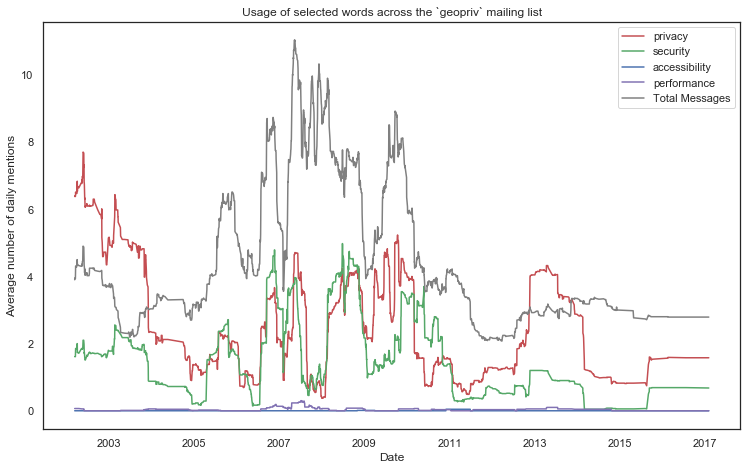

In [46]:
fig = plt.figure(figsize=(12.5, 7.5))

colors = 'rgbm'

window = 90

for i in range(len(checkwords)):
    smooth_sums = date_combined.rolling(window=window, center=False).mean() # rolling average over the window size
    
    plt.plot_date(smooth_sums.index,
                  smooth_sums[checkwords[i]],
                  colors[i],
                  label=checkwords[i])

plt.plot_date(smooth_sums.index, smooth_sums['Messages'], 'gray', label='Total Messages') # show total messages as a comparison
fig.axes[0].set_xlabel('Date')
fig.axes[0].set_ylabel('Average number of daily mentions')
plt.legend()
plt.title('Usage of selected words across the `geopriv` mailing list') #TODO: we could automatically update this title with the lists that were used above
fig.show()
fig.savefig('graphs/word-usage-trends-geopriv.png',dpi=300)